In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

tt = transforms.ToPILImage()
dst = datasets.CIFAR100("~/.torch", download=True, transform=tp)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def weights_init(m):
    try:
        if hasattr(m, "weight") and m.weight is not None:
            m.weight.data.uniform_(-0.5, 0.5)
    except Exception as e:
        print(f'Warning: failed in weights_init for {m._get_name()}.weight. Details: {e}')
    try:
        if hasattr(m, "bias") and m.bias is not None:  # Added 'and m.bias is not None'
            m.bias.data.uniform_(-0.5, 0.5)
    except Exception as e:
        print(f'Warning: failed in weights_init for {m._get_name()}.bias. Details: {e}')

Files already downloaded and verified
Running on cpu


In [3]:
# Define ResNet-20 (for CIFAR-10)
class ResNet20(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet20, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 3, stride=1)
        self.layer2 = self._make_layer(32, 3, stride=2)
        self.layer3 = self._make_layer(64, 3, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return self.linear(out)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

In [4]:
model_shared = ResNet20().to(device)
model_shared.load_state_dict(torch.load("resnet20_cifar10.pth"))

# 2. Freeze all weights
for param in model_shared.parameters():
    param.requires_grad = False

# 3. Remove the final classification layer
# (Replace it with Identity() to keep the feature vector)
model_shared.linear = nn.Identity()

In [5]:
# simplest classifier
class Classifier1(nn.Module):
    def __init__(self, input_dim=64, num_classes=100):
        super(Classifier1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# A bit more complex than classifier 1.
class Classifier2(nn.Module):
    def __init__(self, input_dim=64, num_classes=100, dropout_prob=0.3):
        super(Classifier2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Slightly wider first layer
        self.fc2 = nn.Linear(128, 64)         # Intermediate layer
        self.fc3 = nn.Linear(64, num_classes) # Output layer
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# A bit more complex than classifier 2.
class Classifier3(nn.Module):
    def __init__(self, input_dim=64, num_classes=100, dropout_prob=0.2):
        super(Classifier3, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.norm1 = nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)


In [6]:
classifier = Classifier2().to(device)
classifier.apply(weights_init)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))
criterion = nn.CrossEntropyLoss()

GT label is 84. 
Onehot label is 84.


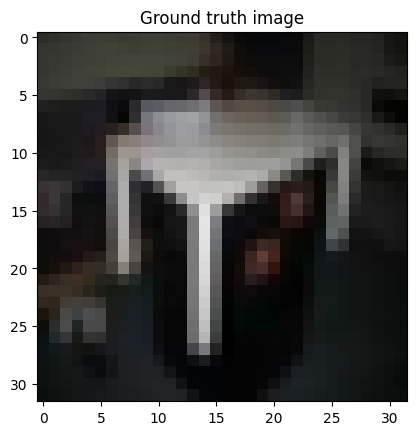

In [7]:
######### honest partipant #########
img_index = 25
gt_data = dst[img_index][0].to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())
# plt.savefig('image1.png')
# plt.show()

In [8]:
# compute original gradient 
ground_truth_feature_matrix =  model_shared(gt_data) # torch.randn((1, 64)).to(device).requires_grad_(True) 
out = classifier(ground_truth_feature_matrix)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, classifier.parameters())
# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# DLG starts here

In [9]:
after_50_iteration = 999999
best_state = {
    'loss': 99999,
    'reconstructed_matrix': None
}

for i in range(50):
    # generate dummy data and label
    dummy_data = torch.randn(ground_truth_feature_matrix.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
    current_loss = None
    
    history = []
    for iters in range(500):
        def closure():
            optimizer.zero_grad()
    
            pred = classifier(dummy_data) 
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, classifier.parameters(), create_graph=True)
            
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()
            
            return grad_diff
        
        optimizer.step(closure)
        if iters % 20 == 0: 
            current_loss = closure()
            # print(iters, "%.4f" % current_loss.item())
        history.append(dummy_data[0].cpu())
        
    if current_loss < after_50_iteration:
        after_50_iteration = current_loss
        best_state['loss'] = current_loss
        best_state['reconstructed_matrix'] = dummy_data
    if current_loss < 0.00001:
        best_state['loss'] = current_loss
        best_state['reconstructed_matrix'] = dummy_data
        break

In [10]:
print('best results from 50 iterations')
print(f"best loss: {best_state['loss']}")
print(f"reconstructed data: {best_state['reconstructed_matrix']}, ground truth {ground_truth_feature_matrix}")

best results from 50 iterations
best loss: 31268.9140625
reconstructed data: tensor([[  -3.8668, -125.8545, -180.9626,  -74.6563,   58.8770,  237.1508,
           58.7959, -138.1024, -105.7960,   13.3949, -148.8306,   72.5349,
         -232.7437,  210.4364,  145.7260,  159.9144,  -49.7592, -172.6244,
          -29.3233,  -72.5181, -119.6697,  142.1348,    5.9675,  209.8351,
         -116.9721,    0.4430,   26.0194,  -77.2023,  115.3932,  216.8689,
         -166.5563,   88.3353,  -31.2429,  -59.3146,   28.0099, -195.9978,
         -109.2310,   99.0364,  -64.0598,  -30.6986,  -41.9937,  -56.8957,
         -125.7026,    5.7151, -203.9180, -150.7401,   96.6960, -201.1729,
          150.0789,   79.8496, -186.3351,  -65.2328,  -22.1324,  -15.5192,
          202.8631,   90.1464,   43.8237,  -55.9034,  -50.2190,   73.6373,
          -63.9623,   58.8460,  -56.0812, -199.5088]], requires_grad=True), ground truth tensor([[1.6594, 1.6851, 1.5739, 1.5922, 1.6475, 1.9456, 1.5760, 1.5572, 1.7283,
   

# iDLG starts here.

In [11]:
out_idlg = classifier(ground_truth_feature_matrix)
criterion = nn.CrossEntropyLoss()
y = criterion(out_idlg, gt_label)
dy_dx = torch.autograd.grad(y, classifier.parameters())
# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [12]:
label_pred =  torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
print(gt_label, label_pred)

tensor([84]) tensor([84])


In [13]:
after_50_iteration = 999999
best_state = {
    'loss': 99999,
    'reconstructed_matrix': None
}

for i in range(50):
    history = []
    dummy_data = torch.randn(ground_truth_feature_matrix.size()).to(device).requires_grad_(True)
    optimizer = torch.optim.Adam([dummy_data], lr=0.01)
    current_loss = None
    
    for iters in range(2000):
        def closure():
            optimizer.zero_grad()
    
            pred = classifier(dummy_data) 
            dummy_loss = criterion(pred, label_pred)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, classifier.parameters(), create_graph=True)
            
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()
            
            return grad_diff
        
        optimizer.step(closure)
        if iters % 100 == 0: 
            current_loss = closure()
            # print(iters, "%.4f" % current_loss.item())
        history.append(dummy_data[0].cpu())
    if current_loss < after_50_iteration:
        after_50_iteration = current_loss
        best_state['loss'] = current_loss
        best_state['reconstructed_matrix'] = dummy_data
    if current_loss < 0.00001:
        best_state['loss'] = current_loss
        best_state['reconstructed_matrix'] = dummy_data
        break

In [14]:
print('best results from 50 iterations')
print(f"best loss: {best_state['loss']}")
print(f"reconstructed data: {best_state['reconstructed_matrix']}, ground truth {ground_truth_feature_matrix}")

best results from 50 iterations
best loss: 19458.314453125
reconstructed data: tensor([[ 0.6114,  0.4547,  0.8057,  0.3445,  0.2909,  0.9583,  0.4908, -0.2084,
          0.8447,  0.7503,  0.4710,  0.1208,  0.0147,  0.3091,  0.4054,  0.2314,
          0.2922, -0.1382, -0.1419,  0.2927,  0.3632,  0.2056,  0.4264,  0.1453,
          0.2593,  0.8768,  0.1191,  0.4203,  0.4049,  0.8425, -0.1377, -0.1704,
          0.5864,  0.4980,  0.7709,  0.5770,  0.1834,  0.5530,  0.8915,  1.2203,
          0.5503,  1.0114,  0.4817,  1.2081,  0.5326, -0.0424, -0.4816,  0.2991,
          0.1812,  0.6026,  0.2039,  1.0254,  0.3908,  0.2498,  0.3799,  0.0597,
          1.0006, -0.2122, -0.1720, -0.3960,  0.9948,  0.3160,  0.0664,  0.4414]],
       requires_grad=True), ground truth tensor([[1.6594, 1.6851, 1.5739, 1.5922, 1.6475, 1.9456, 1.5760, 1.5572, 1.7283,
         1.3682, 1.4964, 1.3229, 1.4383, 1.6828, 1.4704, 1.6110, 1.5296, 1.0040,
         1.6437, 1.8951, 1.6850, 1.4664, 1.4830, 1.4127, 1.5113, 1.3

# R-GAP starts here

In [15]:
class Classifier2_R_GAP(nn.Module):
    def __init__(self, input_dim=64, num_classes=1, dropout_prob=0.3): # num_classes often 1 for these attacks
        super(Classifier2_R_GAP, self).__init__()
        
        act = nn.LeakyReLU(negative_slope=0.2)

        self.body = nn.ModuleList([
            # Block 1, corresponding to original fc1
            nn.Sequential(OrderedDict([
                ('layer', nn.Linear(input_dim, 128, bias=False)),
                ('act', act)
            ])),
            # Block 2, corresponding to original fc2
            nn.Sequential(OrderedDict([
                ('layer', nn.Linear(128, 64, bias=False)),
                ('act', act)
            ])),
            # Block 3, corresponding to original fc3 (output layer)
            nn.Sequential(OrderedDict([
                ('layer', nn.Linear(64, num_classes, bias=False)),
                ('act', nn.Identity()) # No activation after the final layer
            ]))
        ])

    def forward(self, x):
        x_shape = []

        for i, module_seq in enumerate(self.body):
            if isinstance(module_seq.layer, nn.Linear) and x.dim() > 2:
                if i == 0 or not isinstance(self.body[i-1].layer, nn.Linear):
                    x = x.flatten(1)
            
            x_shape.append(x.shape)
            x = module_seq(x)
            
        return x, x_shape
classifier = Classifier2_R_GAP().to(device)

In [16]:
def logistic_loss(y, pred, setup):
    y = torch.as_tensor(y, **setup)
    pred = torch.as_tensor(pred, **setup)

    if pred.shape != y.shape:
        y = y.view_as(pred)
    eps = 1e-7
    pred_clamped = torch.clamp(pred, eps, 1.0 - eps)
    loss = -(y * torch.log(pred_clamped) + (1 - y) * torch.log(1 - pred_clamped))
    return torch.mean(loss)

pred, x_shape = classifier(ground_truth_feature_matrix)

In [17]:
def inverse_udldu(udldu):
    '''derive u from udldu using gradient descend based method'''
    lr = 0.01
    u = torch.tensor(0).to(**setup).requires_grad_(True)
    udldu = torch.tensor(udldu).to(**setup)
    optimizer = torch.optim.Adam([u], lr=lr)
    loss_fn = nn.MSELoss()
    for i in range(30000):
        optimizer.zero_grad()
        udldu_ = -u / (1 + torch.exp(u))
        l = loss_fn(udldu_, udldu)
        l.backward()
        optimizer.step()
    udldu_ = -u / (1 + torch.exp(u))
    print(f"The error term of inversing udldu: {udldu.item()-udldu_.item():.1e}")
    return u.detach().numpy()

def derive_leakyrelu(x, slope):
    return np.array([slope if a < 0 else 1 for a in x]).reshape(1, -1).astype('float32')

def derive_identity(x):
    return np.ones(x.shape).reshape(1, -1).astype('float32')
    
def inverse_leakyrelu(x, slope):
    return np.array([a / slope if a < 0 else a for a in x]).astype('float32')

def inverse_identity(x):
    return x

def peeling(in_shape, padding):
    if padding == 0:
        return np.ones(shape=in_shape, dtype=bool).squeeze()
    h, w = np.array(in_shape[-2:]) + 2*padding
    toremain = np.ones(h*w*in_shape[1], dtype=np.bool)
    if padding:
        for c in range(in_shape[1]):
            for row in range(h):
                for col in range(w):
                    if col < padding or w-col <= padding or row < padding or h-row <= padding:
                        i = c*h*w + row*w + col
                        assert toremain[i]
                        toremain[i] = False
    return toremain

def r_gap(out, k, g, x_shape, weight, module):
    # obtain information of convolution kernel
    if isinstance(module.layer, nn.Conv2d):
        padding = module.layer.padding[0]
        stride = module.layer.stride[0]
    else:
        padding = 0
        stride = 1

    x, weight = cnn_reconstruction(in_shape=x_shape, k=k, g=g, kernel=weight, out=out, stride=stride, padding=padding)
    return x, weight

def cnn_reconstruction(in_shape, k, g, out, kernel, stride, padding):
    coors, x_len, y_len = generate_coordinates(x_shape=in_shape, kernel=kernel, stride=stride, padding=padding)
    K = aggregate_g(k=k, x_len=x_len, coors=coors)
    W = circulant_w(x_len=x_len, kernel=kernel, coors=coors, y_len=y_len)
    P = padding_constraints(in_shape=in_shape, padding=padding)
    p = np.zeros(shape=P.shape[0], dtype=np.float32)
    if np.any(P):
        a = np.concatenate((K, W, P), axis=0)
        b = np.concatenate((g.reshape(-1), out, p), axis=0)
    else:
        a = np.concatenate((K, W), axis=0)
        b = np.concatenate((g.reshape(-1), out), axis=0)
    result = np.linalg.lstsq(a, b, rcond=None)
    print(f'lstsq residual: {result[1]}, rank: {result[2]} -> {W.shape[-1]}, '
          f'max/min singular value: {result[3].max():.2e}/{result[3].min():.2e}')
    x = result[0]
    return x[peeling(in_shape=in_shape, padding=padding)], W

def fcn_reconstruction(k, gradient):
    x = [g / c for g, c in zip(gradient, k) if c != 0]
    x = np.mean(x, 0)
    return x

In [18]:
setup = {'device': 'cpu', 'dtype': torch.float32}
# reversed label to make sure mu is unique, just for better demonstration
y = pred.clone().detach().to(device) # torch.tensor([0 if p > 0 else 1 for p in pred]).to(**setup)
pred.shape, y.shape

(torch.Size([1, 1]), torch.Size([1, 1]))

In [19]:
print(f'pred: {pred.detach().numpy()}, y: {y}')
pred_loss = logistic_loss(pred, y, setup)

pred: [[-0.16705966]], y: tensor([[-0.1671]])


In [20]:
dy_dx = torch.autograd.grad(pred_loss, list(classifier.parameters()))
original_dy_dx = [g.detach().clone() for g in dy_dx]

In [21]:
original_dy_dx.reverse()

In [22]:
modules = classifier.body[-1::-1]
x_shape.reverse()
k = None
last_weight = []
y = torch.tensor([0 if p > 0 else 1 for p in gt_label]).to(**setup)

print('perform R-GAP')
for i in range(len(modules)):
    g = original_dy_dx[i].numpy()
    w = list(modules[i].layer.parameters())[0].detach().cpu().numpy()
    
    if k is None:
        udldu = np.dot(g.reshape(-1), w.reshape(-1))
        print(f'printing udldu {udldu}')
        u = inverse_udldu(udldu)
        print(f'printing u{u}')

        # For simplicity assume y as known here. For details please refer to the paper.
        y = np.array([-1 if n == 0 else n for n in y], dtype=np.float32).reshape(-1, 1)
        y = y.mean() if y.mean() != 0 else 0.1
        
        # print(f'pred_: {u/y:.1e}, udldu: {udldu:.1e}, udldu_:{-u/(1+np.exp(u)):.1e}')
        k = -y/(1+np.exp(u))
        k = k.reshape(1, -1).astype(np.float32)

    else:
        # derive activation function
        if isinstance(modules[i].act, nn.LeakyReLU):
            da = derive_leakyrelu(x_, slope=modules[i].act.negative_slope)
        elif isinstance(modules[i].act, nn.Identity):
            da = derive_identity(x_)
        else:
            ValueError(f'Please implement the derivative function of {modules[i].act}')

        # back out neuron output
        if isinstance(modules[i].act, nn.LeakyReLU):
            out = inverse_leakyrelu(x_, slope=modules[i].act.negative_slope)
        elif isinstance(modules[i].act, nn.Identity):
            out = inverse_identity(x_)
        else:
            ValueError(f'Please implement the inverse function of {modules[i].act}')
        if hasattr(modules[i-1].layer, 'padding'):
            padding = modules[i-1].layer.padding[0]
        else:
            padding = 0

        # For a mini-batch setting, reconstruct the combination
        in_shape = np.array(x_shape[i-1])
        in_shape[0] = 1
        # peel off padded entries
        x_mask = peeling(in_shape=in_shape, padding=padding)
        k = np.multiply(np.matmul(last_weight.transpose(), k)[x_mask], da.transpose())

    if isinstance(modules[i].layer, nn.Conv2d):
        x_, last_weight = r_gap(out=out, k=k, x_shape=x_shape[i], module=modules[i], g=g, weight=w)
    else:
        # In consideration of computational efficiency, for FCN only takes gradient constraints into account.
        x_, last_weight = fcn_reconstruction(k=k, gradient=g), w

perform R-GAP
printing udldu -2.692683219909668
The error term of inversing udldu: -2.4e+00
printing u1.2784645557403564


In [23]:
print(x_)

[122.79957  124.69604  116.46572  117.82588  121.91415  143.97783
 116.625984 115.23172  127.89496  101.243225 110.73123   97.896164
 106.43551  124.52461  108.81148  119.211815 113.19368   74.29433
 121.63076  140.24008  124.68772  108.51068  109.73837  104.542656
 111.83563  102.150604 119.3809   122.17023  112.373566 113.37137
 118.82995  115.59979  122.63084  104.519615  82.118095 114.10348
 116.451866 103.22777  115.99369  116.560585 119.66124  110.96065
 111.21297  127.58522  128.6648   113.932365  85.762566 112.033394
  80.89454  116.66466  103.426    129.9788   104.402054 101.11888
  85.10126  107.71354  116.76297  100.45482  139.55394  106.17704
 124.23931   96.94746   99.37204  134.34943 ]


In [24]:
print(ground_truth_feature_matrix)

tensor([[1.6594, 1.6851, 1.5739, 1.5922, 1.6475, 1.9456, 1.5760, 1.5572, 1.7283,
         1.3682, 1.4964, 1.3229, 1.4383, 1.6828, 1.4704, 1.6110, 1.5296, 1.0040,
         1.6437, 1.8951, 1.6850, 1.4664, 1.4830, 1.4127, 1.5113, 1.3804, 1.6133,
         1.6509, 1.5186, 1.5320, 1.6058, 1.5622, 1.6572, 1.4124, 1.1097, 1.5419,
         1.5737, 1.3950, 1.5675, 1.5751, 1.6170, 1.4995, 1.5029, 1.7241, 1.7387,
         1.5396, 1.1590, 1.5140, 1.0932, 1.5765, 1.3976, 1.7565, 1.4108, 1.3665,
         1.1500, 1.4556, 1.5779, 1.3575, 1.8859, 1.4348, 1.6789, 1.3101, 1.3429,
         1.8155]])
